In [1]:
import torch
from torchvision import datasets, transforms

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/datasets/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/datasets/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

print("done")

done


In [4]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [5]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [6]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[4],
        [5],
        [4],
        [4],
        [4],
        [5],
        [5],
        [4],
        [4],
        [4]])


In [7]:
equals = top_class == labels.view(*top_class.shape)

accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 10.9375%


Exercise: Implement the validation loop below and print out the total accuracy after the loop. 

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = Classifier().to(device)
criterion = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):

    tot_train_loss = 0

    for images, labels in trainloader:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        tot_train_loss += loss.item()


    else:

        tot_test_loss = 0
        test_correct = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images, labels in testloader:

                images, labels = images.to(device), labels.to(device)

                log_ps = model(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # mean loss to compare training and test data
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(train_loss),
                "Test Loss: {:.3f}.. ".format(test_loss),
                "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

cuda
Epoch: 1/30..  Training Loss: 0.008..  Test Loss: 0.007..  Test Accuracy: 0.843
Epoch: 2/30..  Training Loss: 0.006..  Test Loss: 0.007..  Test Accuracy: 0.849
Epoch: 3/30..  Training Loss: 0.006..  Test Loss: 0.006..  Test Accuracy: 0.855
Epoch: 4/30..  Training Loss: 0.005..  Test Loss: 0.006..  Test Accuracy: 0.863
Epoch: 5/30..  Training Loss: 0.005..  Test Loss: 0.006..  Test Accuracy: 0.859
Epoch: 6/30..  Training Loss: 0.005..  Test Loss: 0.006..  Test Accuracy: 0.869
Epoch: 7/30..  Training Loss: 0.005..  Test Loss: 0.006..  Test Accuracy: 0.863
Epoch: 8/30..  Training Loss: 0.004..  Test Loss: 0.006..  Test Accuracy: 0.874
Epoch: 9/30..  Training Loss: 0.004..  Test Loss: 0.006..  Test Accuracy: 0.874
Epoch: 10/30..  Training Loss: 0.004..  Test Loss: 0.006..  Test Accuracy: 0.872
Epoch: 11/30..  Training Loss: 0.004..  Test Loss: 0.006..  Test Accuracy: 0.875
Epoch: 12/30..  Training Loss: 0.004..  Test Loss: 0.006..  Test Accuracy: 0.872
Epoch: 13/30..  Training Loss: 0

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

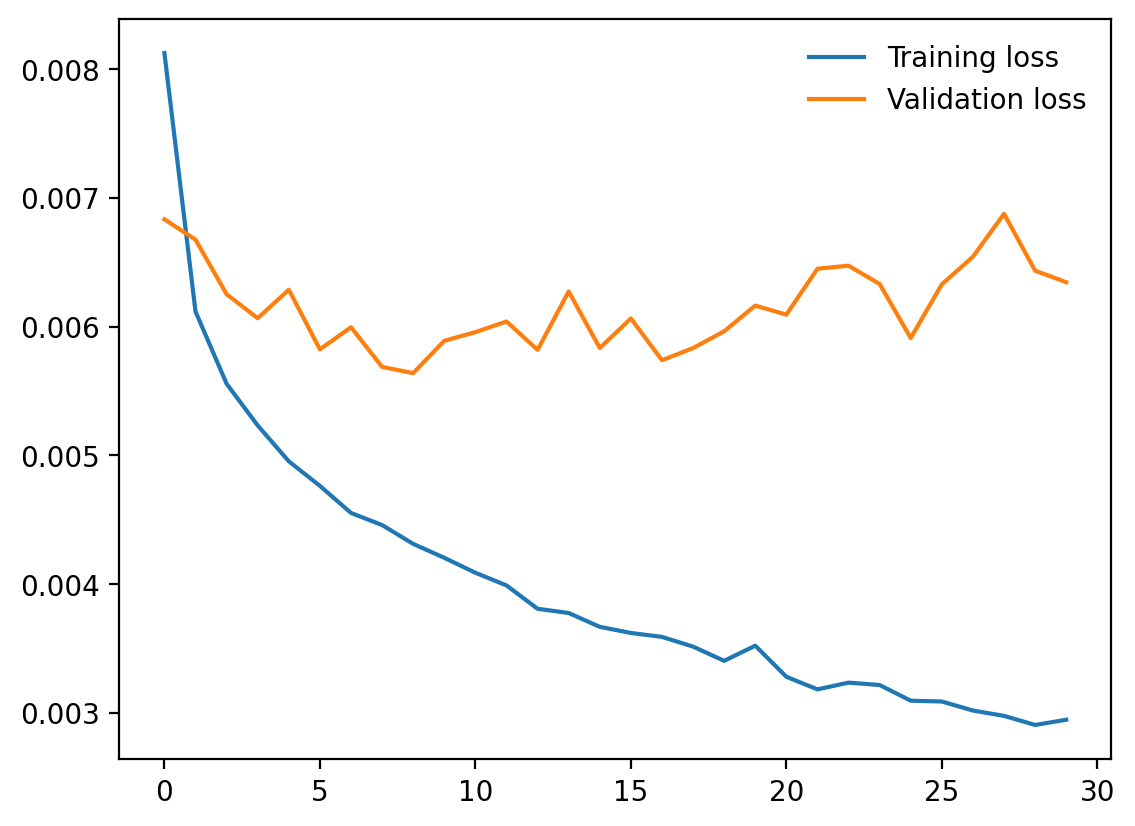

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

Exercise: Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss.

In [13]:
# image is 28 x 28 pixels, so 784 pixels in total
# input layer has 784 units
# output layer has 10 units, one for each class

# define the network architecture

class Network(torch.nn.Module):

    def __init__(self):
        super().__init__()

        # define the layers
        self.fc1 = torch.nn.Linear(784, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 64)
        self.fc4 = torch.nn.Linear(64, 10)

        self.dropout = torch.nn.Dropout(p=0.2)

        # define the activation functions
        self.relu = torch.nn.ReLU()
        self.logsoftmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):

        # flatten   
        x = x.view(x.shape[0], -1)

        # pass through the layers with dropout
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.logsoftmax(self.fc4(x))
        

        return x
    